# Equation of State using Generalized van der Waals Theory

This notebook illustrates the generalized van der Waals theory (gvdW) for the equation of state for interacting particles. Based on the lecture notes, _Properties of Molecular Fluids in Equilibrium_ by Sture Nordholm.

In [18]:
from __future__ import division, unicode_literals, print_function
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import inspect
from scipy.integrate import quad
from ipywidgets import interact
from math import sqrt, pi
plt.rcParams.update({'font.size': 16, 'figure.figsize': [8.0, 6.0]})

### Pair potentials

The particles are here assumed to interact via a Lennard-Jones and a screened Coulomb potential,

$$
\beta w(r) = \frac{\lambda_B z^2}{r} e^{-r/\lambda_D}
+ 4\beta \varepsilon_{LJ} \left ( \left ( \frac{\sigma}{r}\right )^{12} - \left ( \frac{\sigma}{r}\right )^{6}\right )
$$

where $\lambda_B$ and $\lambda_D$ are the Bjerrum and Debye lengths, respectively.
Any potential may in principle be given and must return the energy in units of $k_BT$.

## Define your own potentials below

* The name should start with `potential_`
* The first parameter should be `r`
* The docstring can be added for a nice displayname of the function (The raw python string like `r"$ \mu $"` is convenient when writing latex, because in normal strings the backslash acts as an escape character) 

Datasets. Simple. Something that one can plot. Maybe also with a prefix

In [7]:
from abc import ABCMeta, abstractmethod
import sympy

In [8]:
class Potential(metaclass=ABCMeta):
    @property
    def name(self):
        return self.__class__.__name__
    
    @abstractmethod
    def interaction(self, **kwargs):
        raise NotImplementedError
        
    def ahat(self, **parameters):
        sigma = parameters['sigma']
        # extract the relevant parameters for the potential
        parameters = {k:v for k,v in parameters.items() if k in inspect.signature(potential).parameters}

        def integrand(r):
            return potential(r, **parameters) * r**2
        integral, error = quad(integrand, sigma, np.infty, limit=50)
        return -2 * pi * integral

        

In [9]:
sympy.init_printing()

In [10]:
λb, z, r, λd = sympy.symbols("λb z r λd")

In [11]:
niels = (λb * z**2)/r * sympy.exp(-r / λd)

In [12]:
z = niels.subs({
    λb: 7,
    z: 1,
    r: 2,
    λd: 3.04 / sympy.sqrt(0.15)
})

$$ 
\hat{a} = -\frac{1}{2} \int_{\sigma}^{\infty} 4\pi w(r) r^2 dr
$$


In [13]:
import sympy.core.numbers

In [14]:
nielshat = - sympy.Integral(niels * r**2, (r, 1, sympy.oo)) / 2 * 4 * 3.14159

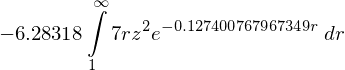

In [15]:
nielshat.subs({
    λb: 7,
    z: 1,
    r: 2,
    λd: 3.04 / sympy.sqrt(0.15)
})

In [16]:
sympy.evaluate(- sympy.Integral(4 * 3.14159 * niels * r**2, (r, 1, sympy.oo)) / 2)

In [17]:
3

In [18]:
class LennardJones(Potential):
    
    
    def interaction(r, eps, sigma):
        pass

In [19]:
LennardJones()

In [20]:
# Debye-Huckel
def potential_wDH(r, z, D):
    r"""$\frac{\lambda_B z^2}{r} e^{-r/\lambda_D}$"""
    lB = 7.0 # Bjerrum length, angstroms
    return lB * z**2 * np.exp(-r/D) / r

# Lennard-Jones
def potential_wLJ(r, eps, sigma):
    r"""$4\beta \varepsilon_{LJ} \left ( \left ( \frac{\sigma}{r}\right )^{12} - \left ( \frac{\sigma}{r}\right )^{6}\right )$"""
    return 4 * eps * ( (sigma/r)**12 - (sigma/r)**6 )

# Total potential
def potential_w(r, z, D, eps, sigma):
    r"""$\frac{\lambda_B z^2}{r} e^{-r/\lambda_D} + 4\beta \varepsilon_{LJ} \left ( \left ( \frac{\sigma}{r}\right )^{12} - \left ( \frac{\sigma}{r}\right )^{6}\right )$"""
    return potential_wDH(r, z, D) + potential_wLJ(r, eps, sigma)

TODO: 

### Interaction parameter

Here we integrate the above pair potential to get the average interaction energy per particle, assuming that the pair correlation function, $g(r)$, can be described by a simple step function, zero when $r<\sigma$, unity otherwise:
$$ 
\hat{a} = -\frac{1}{2} \int_{\sigma}^{\infty} 4\pi w(r) r^2 dr
$$

In this Notebook we simply do the integration numerically so that we can use arbitrary pair potentials.
From this we calculate the pressure, $p$, versus density, $n$, using,

$$
\beta p_{gvdW} = \frac{1}{v-v_0} - \frac{\hat{a}}{v^2}
$$

where $v=1/n$ and $v_0=2\pi\sigma^3/3$ is the particle volume.
For reference we'll also plot EOS for an ideal system (van 't Hoff), $\beta p_{ideal}=n$,
where $\beta = 1/k_BT$.

In [21]:
def ahat(potential, **parameters):
    sigma = parameters['sigma']
    # extract the relevant parameters for the potential
    parameters = {k:v for k,v in parameters.items() if k in inspect.signature(potential).parameters}
    
    def integrand(r):
        return potential(r, **parameters) * r**2
    integral, error = quad(integrand, sigma, np.infty, limit=50)
    return -2 * pi * integral


def ahatexact(z, D, eps, sigma):
    return -2 * pi * (-8/9 * eps * sigma**3 + 7 * np.exp(-sigma/D) * z**2 * (D + sigma))

def Pideal(n):
    return n

def Pgvdw(n, z, D, eps, sigma, potential=potential_w):
    v0 = 2*pi*sigma**3 / 3
    v  = 1 / n
    a = ahat(potential, z=z, D=D, eps=eps, sigma=sigma)
    return 1/(v-v0) - a/v**2

def mu_gvdw(n, d, potential=potential_w, **parameters):
    return np.log(n/(1-n*d**2)) + n * d/(1-n*d**2) - 2 * ahat(potential, **parameters) * n

### Interactive EOS plot

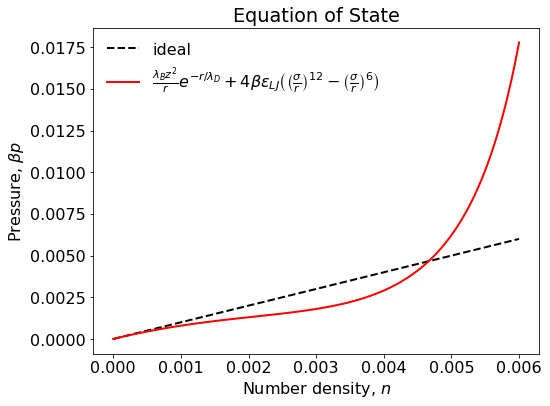

In [22]:
def plot_EOS( eps=1.0, sigma=4.0, z=0.0, Cs=0.3, potential=potential_w):
    D = 3.04/sqrt(Cs)
#     plt.title(potential.__doc__)
    plt.plot(n, Pideal(n),  'k--', label='ideal', lw=2)
    plt.plot(n, Pgvdw(n, z, D, eps, sigma, potential=potential),  'r-', label=potential.__doc__ or potential.__name__, lw=2)
    plt.title('Equation of State')
    plt.xlabel(r'Number density, $n$')
    plt.ylabel(r'Pressure, $\beta p$')
    plt.legend(loc=0, frameon=False)

n = np.linspace(1e-7, 6e-3, 100)

_potentials = {fname: func for fname, func in globals().items() if fname.startswith("potential_")}

i = interact(plot_EOS,
             eps=(0.0, 10.0, 0.1), 
             sigma=(0, 5, 0.1),
             z=(0.0, 10, 1.0), 
             Cs=(1e-3, 1.0, 0.1), 
             potential = _potentials )

plt.title('Equation of State')
plt.xlabel(r'Number density, $n$')
plt.ylabel(r'Pressure, $\beta p$')
plt.legend(loc=0, frameon=False)
 
i.widget.children[0].description=r'$\beta\varepsilon_{LJ}$'
i.widget.children[1].description=r'$\sigma_{LJ}$'
i.widget.children[2].description=r'$z$'
i.widget.children[3].description=r'$c_s$ (M)'

In [23]:
from bokeh.io import show, output_notebook, push_notebook
from bokeh.plotting import figure

In [24]:
output_notebook()

Loading BokehJS ...

In [25]:
def mu_harddisk(n, d):
    return n * d**2 / (1 - n * d**2)

In [26]:
potfig = figure(title="Excess potential",
               plot_height=300, plot_width=600,
               x_axis_label="Number density n", y_axis_label="Potential (k T)")
hd_line = potfig.line(n, mu_harddisk(n, 12), legend="Harddisk")
gvdw_line = potfig.line(n, mu_gvdw(n, d=12, z=0, D=3.04/sqrt(0.3), eps=1, sigma=4, potential=potential_w), color="green", legend="GvdW")
potfig_handle = show(potfig, notebook_handle=True)



In [33]:
start_interaction();

In [27]:
fig = figure(title="Bokeh plot", 
             plot_height=300, plot_width=600,
             x_axis_label='Number density n', y_axis_label="Pressure, βp")
ideal_line = fig.line(n, Pideal(n), legend="Ideal",)
other_line = fig.line(n, Pgvdw(n, z=0, D=3.04/sqrt(0.3), eps=1, sigma=4, potential=potential_w), 
                      color="green", legend="other")
fig.legend.click_policy = "hide"
fig.legend.location = "top_left"

In [28]:
def update(eps=1.0, sigma=4.0, z=0.0, Cs=0.3, potential=potential_w):
    D = 3.04/sqrt(Cs)
    other_line.data_source.data["y"] = Pgvdw(n, z, D, eps, sigma, potential)
    push_notebook(handle=fig_handle)

In [29]:
from functools import partial
start_interaction = partial(interact, update, 
                            eps=(0.0, 10.0, 0.1), 
                            sigma=(0, 5, 0.1), 
                            z=(0.0, 10, 1.0),
                            Cs=(1e-3, 1.0, 0.1), potential=_potentials)

In [30]:
fig_handle = show(fig, notebook_handle=True)

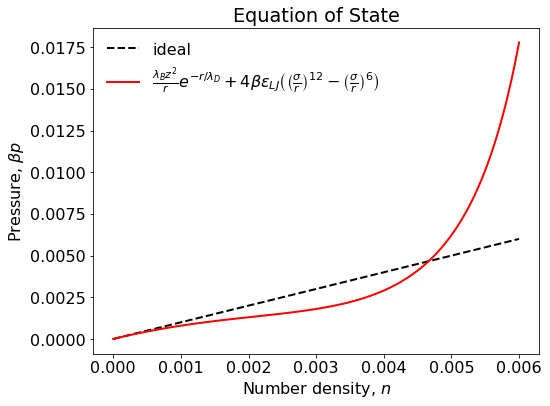

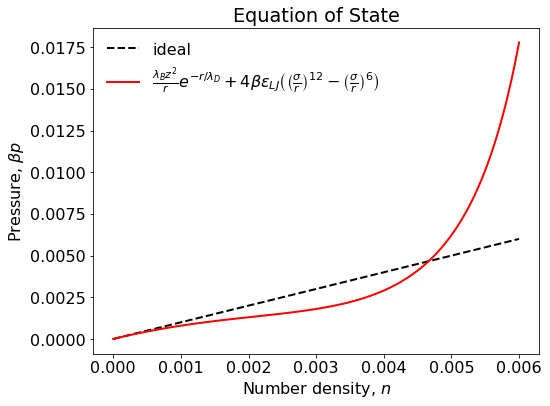

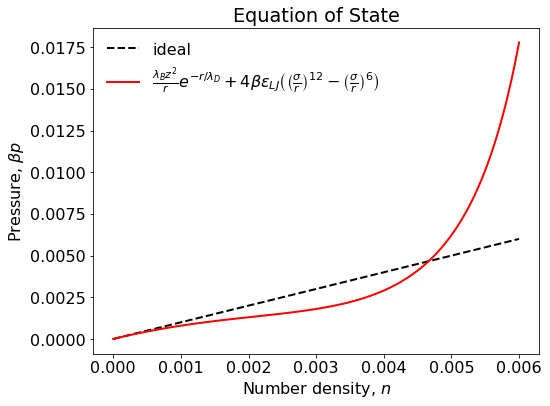

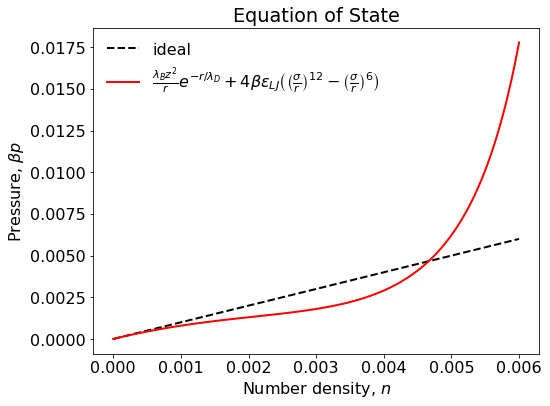

In [32]:
def plot_EOS( eps=1.0, sigma=4.0, z=0.0, Cs=0.3, potential=potential_w):
    D = 3.04/sqrt(Cs)
#     plt.title(potential.__doc__)
    plt.plot(n, Pideal(n),  'k--', label='ideal', lw=2)
    plt.plot(n, Pgvdw(n, z, D, eps, sigma, potential=potential),  'r-', label=potential.__doc__ or potential.__name__, lw=2)
    plt.title('Equation of State')
    plt.xlabel(r'Number density, $n$')
    plt.ylabel(r'Pressure, $\beta p$')
    plt.legend(loc=0, frameon=False)

n = np.linspace(1e-7, 6e-3, 100)

_potentials = {fname: func for fname, func in globals().items() if fname.startswith("potential_")}

i = interact(plot_EOS,
             eps=(0.0, 10.0, 0.1), 
             sigma=(0, 5, 0.1),
             z=(0.0, 10, 1.0), 
             Cs=(1e-3, 1.0, 0.1), 
             potential = _potentials )

plt.title('Equation of State')
plt.xlabel(r'Number density, $n$')
plt.ylabel(r'Pressure, $\beta p$')
plt.legend(loc=0, frameon=False)
 
i.widget.children[0].description=r'$\beta\varepsilon_{LJ}$'
i.widget.children[1].description=r'$\sigma_{LJ}$'
i.widget.children[2].description=r'$z$'
i.widget.children[3].description=r'$c_s$ (M)'

In [34]:
%store -r dataset

In [35]:
dataset

{'charged':                         length  potential       density
 charged_length:1414     1414.0   0.056675   1000.302091
 chargedxtc_length:1414  1414.0   0.056675   1000.302091
 charged_length:1000     1000.0   0.116754   2000.000000
 chargedxtc_length:1000  1000.0   0.116754   2000.000000
 charged_length:816       816.0   0.152403   3003.652441
 chargedxtc_length:816    816.0   0.172535   3003.652441
 charged_length:632       632.0   0.306024   5007.210383
 chargedxtc_length:632    632.0   0.306024   5007.210383
 charged_length:535       535.0   0.446820   6987.509826
 chargedxtc_length:535    535.0   0.446820   6987.509826
 charged_length:471       471.0   0.599234   9015.466032
 chargedxtc_length:471    471.0   0.599234   9015.466032
 charged_length:426       426.0   0.741775  11020.741035
 chargedxtc_length:426    426.0   0.741775  11020.741035
 charged_length:392       392.0   0.906762  13015.410246
 chargedxtc_length:392    392.0   0.906762  13015.410246,
 'chargedxtc':     

In [1]:
import pandas as pd

In [2]:
pd.read_csv("/Users/niels/proj/thesis/experiments/harddisks/large_hardisk.txt")

,1.414000000000000000e+03 1.429585460731450097e-01 2.000000000000000000e+01 1.000302091231552026e+03
0,9.990000000000000000e+02 2.990882091428900269e...
1,8.160000000000000000e+02 4.684432472751309806e...
2,6.320000000000000000e+02 8.629727385734929923e...
3,5.340000000000000000e+02 1.353602607621670062e...
4,4.710000000000000000e+02 1.970895704549270100e...
5,4.260000000000000000e+02 2.788653065634310035e...
6,3.920000000000000000e+02 3.842403663548089821e...


In [3]:
!cat "/Users/niels/proj/thesis/experiments/harddisks/large_hardisk.txt"

1.414000000000000000e+03 1.429585460731450097e-01 2.000000000000000000e+01 1.000302091231552026e+03
9.990000000000000000e+02 2.990882091428900269e-01 2.000000000000000000e+01 2.004006008010011783e+03
8.160000000000000000e+02 4.684432472751309806e-01 2.000000000000000000e+01 3.003652441368703876e+03
6.320000000000000000e+02 8.629727385734929923e-01 2.000000000000000000e+01 5.007210382951449901e+03
5.340000000000000000e+02 1.353602607621670062e+00 2.000000000000000000e+01 7.013704779138435697e+03
4.710000000000000000e+02 1.970895704549270100e+00 2.000000000000000000e+01 9.015466031977857710e+03
4.260000000000000000e+02 2.788653065634310035e+00 2.000000000000000000e+01 1.102074103462716812e+04
3.920000000000000000e+02 3.842403663548089821e+00 2.000000000000000000e+01 1.301541024573094546e+04


In [6]:
with open("datafile.csv", "wt") as stream:
    stream.write("""\
length potential proteins density
1.414000000000000000e+03 1.429585460731450097e-01 2.000000000000000000e+01 1.000302091231552026e+03
9.990000000000000000e+02 2.990882091428900269e-01 2.000000000000000000e+01 2.004006008010011783e+03
8.160000000000000000e+02 4.684432472751309806e-01 2.000000000000000000e+01 3.003652441368703876e+03
6.320000000000000000e+02 8.629727385734929923e-01 2.000000000000000000e+01 5.007210382951449901e+03
5.340000000000000000e+02 1.353602607621670062e+00 2.000000000000000000e+01 7.013704779138435697e+03
4.710000000000000000e+02 1.970895704549270100e+00 2.000000000000000000e+01 9.015466031977857710e+03
4.260000000000000000e+02 2.788653065634310035e+00 2.000000000000000000e+01 1.102074103462716812e+04
3.920000000000000000e+02 3.842403663548089821e+00 2.000000000000000000e+01 1.301541024573094546e+04""")

In [15]:
df = pd.read_csv("datafile.csv", delimiter="(?:\s+|,)", engine="python")

In [17]:
density, potential = df.density, df.potential

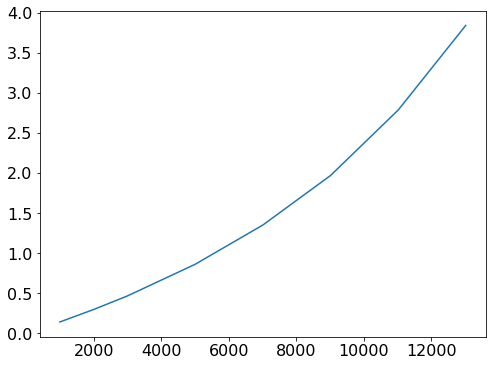

In [19]:
plt.plot(density, potential)